# Visual Transformers

ViT model for image classification using the CIFAR10 dataset. 


In [1]:
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from patchify import patchify
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torch.utils.data import random_split

# Data Loading

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


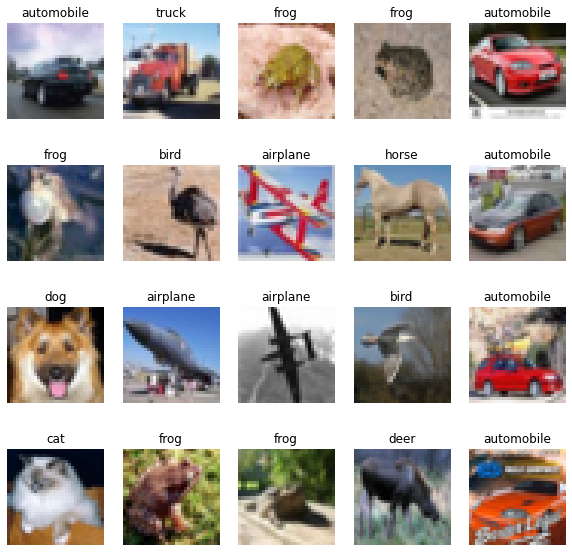

In [3]:
show_transform = transforms.Compose([
    transforms.ToTensor()])
new_dict = {value:key for (key,value) in train_dataset.class_to_idx.items()}
new_dict[0]
train_dataset_show = torchvision.datasets.CIFAR10('./', train=True, download=True,transform=show_transform)
test_dataset_show = torchvision.datasets.CIFAR10('./', train=False, download=True,transform=show_transform)
number_images_to_plot=21
total_image_number=len(train_dataset_show)
images_indecies=np.random.choice(total_image_number, number_images_to_plot, replace=False)
columns=int(np.round(np.sqrt(number_images_to_plot)))
rows=int(number_images_to_plot/columns)
fig = plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    img = train_dataset_show[images_indecies[i-1]][0]
    lbl = new_dict[train_dataset_show[images_indecies[i-1]][1]]
    fig.add_subplot(rows, columns, i)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
plt.show()


## exploratory data analysis (EDA)

train dataset contains 50000 labels
test dataset contains 10000 labels

10 labels:
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

samples per label:


<AxesSubplot:xlabel='0'>

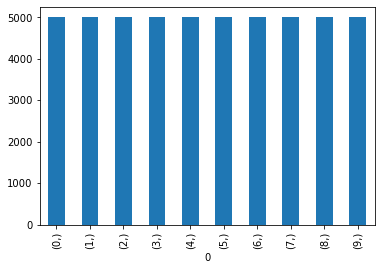

In [4]:


# How many samples in train/test?                                            #
print("train dataset contains {} labels".format(len(train_dataset)))
print("test dataset contains {} labels".format(len(test_dataset)))

# How many labels?                          #
print("\n{} labels:".format(len(train_dataset.class_to_idx)))
print(train_dataset.class_to_idx)

# How many samples per label?     
print('\nsamples per label:')
pd.DataFrame(train_dataset.targets).value_counts().plot(kind="bar")

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Create DataLoaders

In [5]:
batch_size=32

train_size = int(len(train_dataset) * 0.8) # 80% training data
valid_size = len(train_dataset) - train_size # 20% validation data
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size,
                        shuffle=True, num_workers=0)

valid_dataloader = DataLoader(valid_data, batch_size=batch_size,
                        shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

# Building ViT Model

construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

the ViT model using a pre-built Encoder from the PyTorch library.

In [6]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, hidden_dim, 
                 mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        
        torch._assert(image_size % patch_size == 0, "Input shape indivisible by patch size!")
        self.image_size = image_size
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim
        self.attention_dropout = attention_dropout
        self.dropout = dropout
        self.num_classes = num_classes
        
        # initializing the encoder backbone
        # you should calculate the seq_length
        seq_length = int(image_size / patch_size) ** 2
        self.encoder = Encoder(
        seq_length=seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )
        
        self.seq_length = seq_length
        self.head = nn.Linear(self.hidden_dim, self.num_classes)

    def forward(self,x):
        # x should be a 4 dimension tesnor (b,c,h,w)
        x_patches = self.patches_create(x)
        x_patches = self.encoder(x_patches)
        x_patches=x_patches.mean(dim=1)
        x_patcehs = self.head(x_patches)
        return x_patcehs
    def patches_create(self,imgs):
        #Expand batch dim in case got one image
        if len(imgs.shape) == 3:
            imgs = imgs.unsqueeze(0)
        #imgs=np.array(imgs)
        patches = rearrange(imgs, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=self.patch_size, s2=self.patch_size)
        return patches
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        ###################
        # train the model #
        ###################
        self.encoder.train()
        self.head.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output=output.argmax(dim=1)[:-1]
            # calculate the batch loss
            #target=target.to(dtype=torch.long)
            #output=output.to(dtype=torch.long)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            optimizer.step()
            if i % 100 == 0:
                print(f"\tBATCH {i + 1}/{len(train_loader)} - LOSS: {loss}")
        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)
    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        self.encoder.eval()
        self.head.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.forward(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)


In [7]:
model = ViT(image_size=32, patch_size=8, num_classes=100, num_layers=2, num_heads=2, hidden_dim=192, 
                 mlp_dim=512, dropout=0.0, attention_dropout=0.0)

# Training

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
lr = 1e-4
epochs=10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train_one_epoch(train_dataloader,criterion,optimizer,device)
model.validate_one_epoch(valid_dataloader,criterion,device)

train_acc=[]
train_loss=[]
valid_acc=[]
valid_loss=[]
for epoch in range(epochs):
    print(epoch)
    epoch_loss,epoch_acc=model.train_one_epoch(train_dataloader, criterion, optimizer, device)
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    epoch_loss,epoch_acc=model.validate_one_epoch(valid_dataloader, criterion, device)
    valid_acc.append(epoch_acc)
    valid_loss.append(epoch_loss)


## Loss and Acurracy

In [13]:
# Plot 2 graphs:
# Graph 1: Loss vs itreation for training and validation sets
# Graph 2: Accuracy vs itreation for training and validation sets

In [242]:
train_loss_n=[float(i) for i in train_loss]

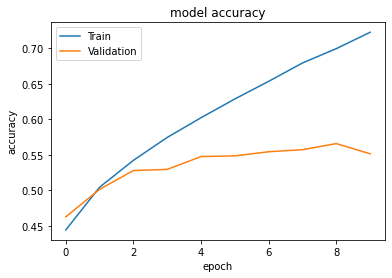

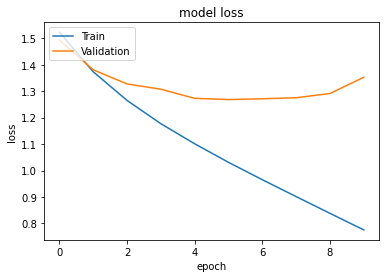

In [243]:
# summarize history for accuracy
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_loss_n)
plt.plot(valid_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation 

In [14]:
# Calculate the accuracy of the final model on the test set.

In [254]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iterations=0
test_acc=[]
for data, target in test_dataloader:
    if device.type == "cuda":
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = model.forward(data)
        accuracy = (output.argmax(dim=1) == target).float().mean()
    iterations+=1
    test_acc.append(accuracy)
np.array(test_acc).mean()

0.5496206

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


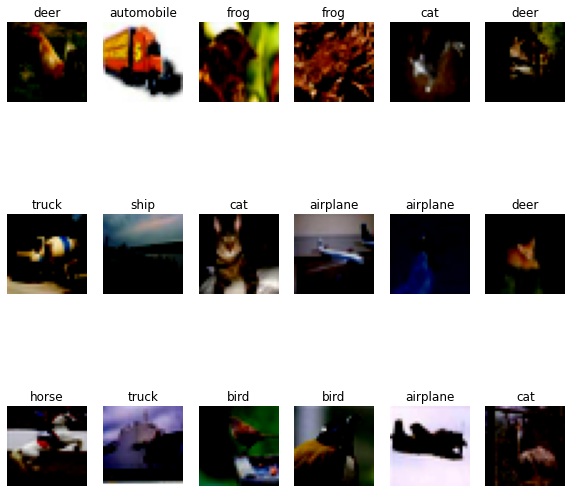

In [286]:
data, target = next(iter(test_dataloader))   
if device.type == "cuda":
    data, target = data.cuda(), target.cuda()
with torch.no_grad():
    output = model.forward(data).argmax(dim=1)
new_dict = {value:key for (key,value) in train_dataset.class_to_idx.items()}
columns=int(np.round(np.sqrt(batch_size)))
rows=int(number_images_to_plot/columns)
fig = plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    img = data[i-1]
    lbl = new_dict[int(output[i-1])]
    fig.add_subplot(rows, columns, i)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
print(test_dataset.class_to_idx)
plt.show()

#### Did the same with untrained ViT in order to compare results - indeed I see untrained model has worse results compared to trained ViT 

In [273]:
untrained_model = ViT(image_size=32, patch_size=8, num_classes=10, num_layers=2, num_heads=2, hidden_dim=192, 
                 mlp_dim=512, dropout=0.0, attention_dropout=0.0)

In [274]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
iterations=0
test_acc=[]
for data, target in test_dataloader:
    if device.type == "cuda":
        data, target = data.cuda(), target.cuda()
    with torch.no_grad():
        output = untrained_model.forward(data)
        accuracy = (output.argmax(dim=1) == target).float().mean()
    iterations+=1
    test_acc.append(accuracy)
np.array(test_acc).mean()

0.11331869

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


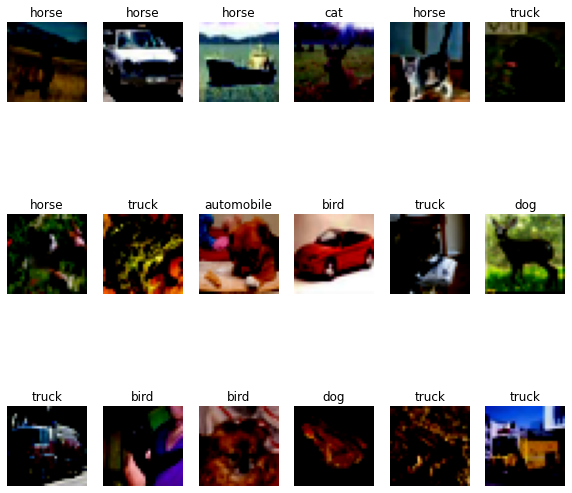

In [287]:
data, target = next(iter(test_dataloader))   
if device.type == "cuda":
    data, target = data.cuda(), target.cuda()
with torch.no_grad():
    output = untrained_model.forward(data).argmax(dim=1)

columns=int(np.round(np.sqrt(batch_size)))
rows=int(number_images_to_plot/columns)
fig = plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    img = data[i-1]
    lbl = new_dict[int(output[i-1])]
    fig.add_subplot(rows, columns, i)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))
print(test_dataset.class_to_idx)
plt.show()



# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:** In ViT model encoders get as input and process all input data in parallel and word-embedding can help the model incorporate the order of words. for example, if encoder input is: "Mouse  eating cheese" or "Cheese eating mouse" - without positional encoding both inputs has the same meaning but in case of positional embedding the model can observe between the cases and get the correct position for each input element/token.

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:** There are few solutions that i can think of:
1. Weighted Random Sampler - in each iteration sample the same amount of samples per class, than the accuracy per iteration and per epoch is calculated with balance.

2. Weighted accuracy calculation - calculate accuracy with weight per class. count how many classes was taken in each batch and calculate the accuracy with the correct weights.